In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, re, tqdm, json
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr, linregress

In [2]:
import sys, os
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)
from constants import patient_names, max_kr_panpep

In [15]:
parameters_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters')
parameters_df['patient_with_region'] = parameters_df['Patient'] + '_' + parameters_df['Region']
parameters_df

,Patient,Region,x1_panpep,x2_panpep,nll_panpep,x1_vdjdb,x2_vdjdb,nll_vdjdb,x1_mcpas,x2_mcpas,nll_mcpas,patient_with_region
0,BrMET008,combined,100,2.886680,922.615085,100,2.552063,897.643629,100,2.628845,897.507744,BrMET008_combined
1,BrMET008,region1,100,3.064290,662.269808,100,2.737427,645.355135,100,2.793823,646.793680,BrMET008_region1
2,BrMET008,region2,100,2.318002,170.019577,100,2.033386,163.730237,100,2.134399,163.469983,BrMET008_region2
3,BrMET008,region3,100,1.231491,20.988472,100,1.164917,20.509720,100,1.169067,21.030471,BrMET008_region3
4,BrMET008,region4,100,1.901261,67.395142,100,1.791504,67.270998,100,1.879395,68.424562,BrMET008_region4
...,...,...,...,...,...,...,...,...,...,...,...,...
69,GBM074,region3,100,5.102999,941.626196,100,4.399902,911.991038,100,5.762878,934.986348,GBM074_region3
70,GBM079,combined,100,2.171706,1438.066747,100,1.935791,1385.091860,100,1.861389,1390.841532,GBM079_combined
71,GBM079,region1,100,3.064789,257.019188,100,2.365784,244.705973,100,2.429932,243.421893,GBM079_region1
72,GBM079,region2,100,6.293982,900.897039,100,5.585999,859.443064,100,5.435181,865.558114,GBM079_region2


In [22]:
column_names = ['patient', 'mean_kr', 'mean_clone_size']
df = pd.DataFrame(columns=column_names)
for patient_id in patient_names:
    parent_dir = f'/home/gddaslab/mxp140/tcr_project_ultimate/data/glioblastoma_data/PANPEP/{patient_id}'
    filenames = [file for file in os.listdir(parent_dir) if file.startswith(patient_id)]
    pid_with_region_label = [file[:-4] for file in filenames]
    filepaths = [os.path.join(parent_dir, file) for file in filenames]
    for i, file in enumerate(filepaths):
        temp_df = pd.read_csv(file, sep=',')
        x2_panpep = parameters_df[parameters_df['patient_with_region']==pid_with_region_label[i]]['x2_panpep'].values[0]
        df = pd.concat([df, pd.DataFrame([[pid_with_region_label[i], x2_panpep * temp_df['kr'].mean()/max_kr_panpep, temp_df['counts'].mean()]], columns=column_names)], ignore_index=True)

/tmp/ipykernel_1477486/3251098428.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([[pid_with_region_label[i], x2_panpep * temp_df['kr'].mean()/max_kr_panpep, temp_df['counts'].mean()]], columns=column_names)], ignore_index=True)


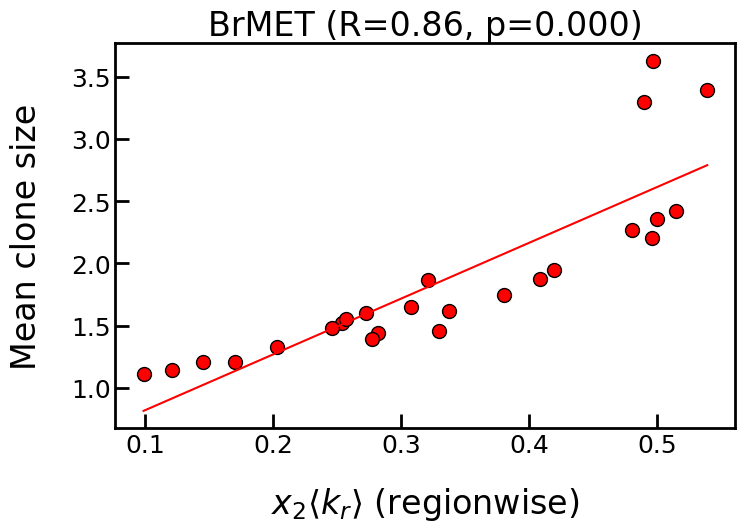

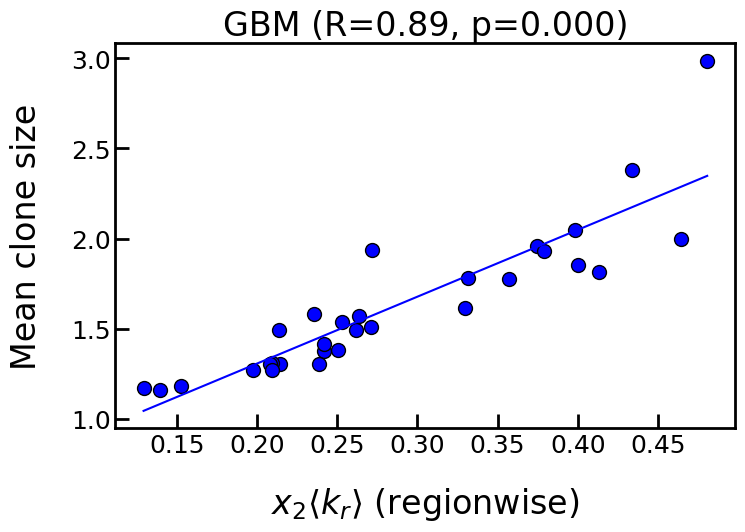

In [28]:
x_values = df['mean_kr'].values
y_values = df['mean_clone_size'].values

brmet_mask = df['patient'].str.contains('BrMET')
gbm_mask = df['patient'].str.contains('GBM')

corr_all = pearsonr(x_values, y_values)
corr_brmet = pearsonr(x_values[brmet_mask], y_values[brmet_mask])
corr_gbm = pearsonr(x_values[gbm_mask], y_values[gbm_mask])

mask = [brmet_mask, gbm_mask]
colors = ['red', 'blue']
titles = [f'BrMET (R={corr_brmet.statistic:.2f}, p={corr_brmet.pvalue:.3f})', f'GBM (R={corr_gbm.statistic:.2f}, p={corr_gbm.pvalue:.3f})']
for i in range(2):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
    x = x_values[mask[i]]
    y = y_values[mask[i]]
    # print(min(x), max(x))
    # print(min(y), max(y))
    ax.scatter(x, y, s=100, color=colors[i], edgecolor='black', alpha=1)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    x_range = np.linspace(min(x), max(x), 1000)
    ax.plot(x_range, slope * x_range + intercept, color=colors[i], )
    ax.set_xlabel(r'$x_2 \langle k_r \rangle$ (regionwise)', fontsize=24)
    ax.set_ylabel(r'Mean clone size', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=16)
    xtick_labels, ytick_labels = ax.get_xticklabels(), ax.get_yticklabels()
    for label in xtick_labels + ytick_labels:
        label.set_fontsize(24)
    ax.tick_params(
        axis="x", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="x", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="major", direction="in", length=10, width=2, labelsize=18
    )
    ax.tick_params(
        axis="y", which="minor", direction="in", length=5, width=2, labelsize=18
    )
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.yaxis.labelpad = 20
    ax.xaxis.labelpad = 20
    ax.set_title(titles[i], fontsize=24)
    plt.show()